# Восстановление матрицы корреспонденций

                            Автор: Сергей Павлов

В настоящем документе изложен отчёт о проделанной работе по вышеуказанной теме. 
### План работы    
- Применение классического метода восстановления(из лекции)
- Обсуждение метрики в классическом подходе
- Описание и применение статистического подхода 
- Обсуждение результатов

Импортируем необходимые библиотеки и загрузим данные:

In [296]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.distributions
from tensorflow.distributions import Dirichlet, Multinomial
from scipy.stats import entropy
df = pd.read_csv('trips1.csv')

## Часть 1: классический метод

Таблица trips.csv содержит 210 строк, тогда как возможных различных пар локаций имеется $22*(22 - 1) / 2 = 242$. Это означает, что для некоторых порядоченных пар локаций не нашлось людей, живущих в первой и работающих во второй. Для применения стандартного подхода положим время по отсутствующим (в обоих направлениях) корреспонденциям равным бесконечности, а соответствующие корреспонденции - нулю.

Здесь как и в лекциях:

$$\sum_j d_{ij} = L_i$$
$$\sum_i d_{ij} = W_j$$

In [379]:
# инициализируем таблицы
d = np.zeros((22,22))
T = np.inf * np.ones((22,22))

# заполняем таблицы
for v in df.values:
    d[int(v[0]) - 1, int(v[1]) - 1] = v[2]
    T[int(v[0]) - 1, int(v[1]) - 1] = v[3]
    T[int(v[1]) - 1, int(v[0]) - 1] = v[3]

# вычисляем L и W   
L = d.sum(axis = 1).reshape((22,1))
W = d.sum(axis = 0).T.reshape((22,1))

Зададим функцию iterate, выполняющую одну итерацию процесса(n = 22):

$$A^{n+1}_i := \left(\sum_{j=1}^n{\frac{B_j^nW_j}{\exp{\alpha T_{ij}}}}\right)^{-1},$$

$$B^{n+1}_j := \left(\sum_{i=1}^n{\frac{A_i^{n+1}L_i}{\exp{\alpha T_{ij}}}}\right)^{-1}$$

Код написан в векторной форме с целью оптимизации времени выполнения:

In [318]:
def iterate(A, B, W, L, f, n):
    A_p = (1.0 / ((B.T * W.T * f).sum(axis = 1))).reshape((n,1))
    B_p = (1.0 / ((A_p * L * f).sum(axis = 0))).T.reshape((n,1))
    return A_p, B_p

Зададим функцию, которая выполняет заданное число итераций оптимизации для заданного значения $\alpha$. Функция возвращает восстановленную матрицу $\widetilde{(d_{ij})_{i,j = 1}^{n}}$, а также графики $\frac{|dA_{n+1}|_2}{|A_n|_2}$ и $\frac{|dB_{n+1}|_2}{|B_n|_2}$ в зависимости от номера итерации. Графики позволят нам сравнить скорость сходимости для различных значений $\alpha$.

Мы инициализировали A и B единицами, а также случайными величинами(между 0 и 1). На величину невязки и оптимальное значение параметра $\alpha$ метод инициализации не повлиял. 

In [319]:
def calculate_for_alpha(alpha, iterations, p = False):

    A = np.random.random((22,1))
    B = np.random.random((22,1))
    #A = np.ones((22,1))
    #B = np.ones((22,1))
    
    dA = []
    dB = []
    f_a = np.exp(-alpha * T)

    for i in range(iterations):
        
        A_n, B_n = iterate(A,B,W,L,f_a,22)
        
        dA_ =  np.linalg.norm(A - A_n, 2) / np.linalg.norm(A, 2)
        dB_ = np.linalg.norm(B - B_n, 2) / np.linalg.norm(B, 2)
        
        dA.append(dA_)
        dB.append(dB_)
        
        A,B = A_n, B_n
    
    if p:
        plt.subplot(2, 1, 1)
        plt.scatter(range(20,iterations), dA[20:], s = 1)
        plt.ylabel('|dA|/|A|')

        plt.subplot(2, 1, 2)
        plt.scatter(range(20,iterations), dB[20:], s = 1)
        plt.ylabel('|dB|/|B|')
        plt.xlabel('iterations')

        plt.show()

    return np.dot((A * L) , (B * W).T) * f_a

Экстремальные значения $\alpha$ влекут за собой зануление компонент A и B и впоследствии деление на 0. Перебирая значения $\alpha$ в коде ниже, убеждаемся, что 2500 итераций достаточно для обеспечения сходимости для разумных значений $\alpha$ ($\alpha < 9$). Для малых значений $\alpha$ сходимость быстрее. 

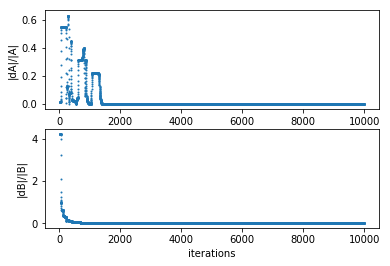

In [381]:
r = calculate_for_alpha(5, 10000, p = True)

Определившись с числом итераций(2500), посмотрим на зависимость невязки, последовательно сужая окно поиска. 

C:\Users\Sergey\AppData\Local\conda\conda\envs\condathree\lib\site-packages\ipykernel\__main__.py:36: RuntimeWarning: invalid value encountered in multiply


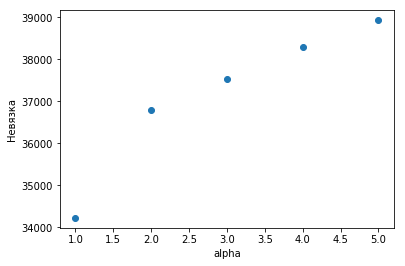

In [321]:
### Окно значений alpha: 1-9####
res = []
alphas = range(1,9)
for alpha in alphas:
    r = calculate_for_alpha(alpha, 2500)
    res.append(np.sum((r - d)*(r - d)))

plt.scatter(alphas, res)
plt.ylabel('Невязка')
plt.xlabel('alpha')
plt.show()

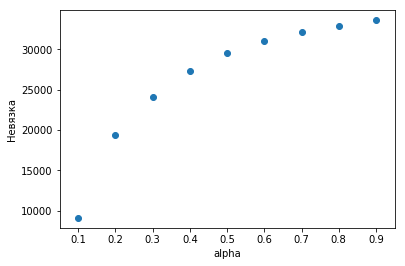

In [322]:
### Окно значений alpha: 0.1-1.0####
res = []
alphas = np.arange(0.1,1.0,0.1)
for alpha in alphas:
    r = calculate_for_alpha(alpha, 2500)
    res.append(np.sum((r - d)*(r - d)))

plt.ylabel('Невязка')
plt.xlabel('alpha')
plt.scatter(alphas, res)
plt.show()

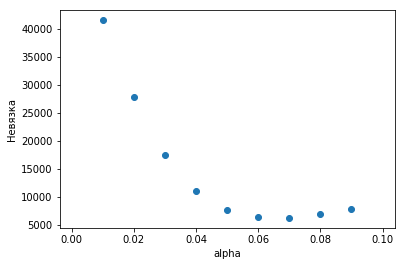

In [323]:
### Окно значений alpha: 0.01-0.1####
res = []
alphas = np.arange(0.01,0.1,0.01)
for alpha in alphas:
    r = calculate_for_alpha(alpha, 2500)
    res.append(np.sum((r - d)*(r - d)))

plt.scatter(alphas, res)
plt.ylabel('Невязка')
plt.xlabel('alpha')
plt.show()

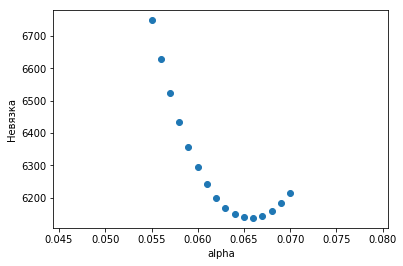

In [324]:
res = []
alphas = np.arange(0.055,0.07,0.001)
for alpha in alphas:
    r = calculate_for_alpha(alpha, 2500)
    res.append(np.sum((r - d)*(r - d)))

plt.ylabel('Невязка')
plt.xlabel('alpha')
plt.scatter(alphas, res)
plt.show()

### Выводы:

- Оптимальное значение невязки($\approx 6150$) достигается при значении $\alpha \approx 0.066$ 
- Для обеспечения сходимости метода достаточно произвести 2500 операций, а для малых значений $\alpha$($\alpha < 1$) - на порядок меньше
- В близи экстремума функция невязки является выпуклой, однако на всём множестве значений это неверно

## Часть 2: обсуждение метрики

В данном разделе предлагается несколько иначе посмотреть на постановку задачи восстановления матрицы корреспонденций.

Рассмотрим классическую гравитационную модель:

$$d_{ij} = \frac{A_iB_jL_iW_j}{f_{\alpha}(T_{ij})}$$

Разделим обе части уравнения на $L_i$:

$$\frac{d_{ij}}{L_i} = \frac{A_iB_jW_j}{f_{\alpha}(T_{ij})}$$

В левой части этого уравнения стоит доля жителей локации i, которые работают в j. Понятно, что 

$$\left(p_i(j):= \frac{d_{ij}}{L_i}\right)_{j=1}^n$$

формирует некоторое распределение $p_i$ на множестве локаций. В этой связи интересны следующие вопросы:

- Каким образом можно сравнить распределения по городам для разных i c эталоном?

- Будет ли оптимальное значение невязки в таких терминах отличаться от оптимального значений в классической постановке?

Мы предлагаем использовать в качестве невязки симметричную KL-метрику:

$\sum_{i = 1}^n(KL(\tilde{p_i}|| p_i) + KL(p_i|| \tilde{p_i}))$

Проблемой является наличие нулевых значений в $d_{ij}$. Эту проблему мы решим следующим образом: бесконечные значения $T_{ij}$ мы заменим большим временем в пути(240 минут), а нулевые значения $d_{ij}$ заменим значеним 1. Второе, конечно, статистически более существенно, посколько опрошено всего порядка 1500 человек, и реальной вероятности для этих нулевых корреспонденций мы не знаем, но за неимением лучшего решения поступим так. Отметим также, что оптимальное значение $\alpha$ для классического метода на исправленных матриц составляет $\approx 0.057$ при значении классической невязки $\approx$ 8250.

In [325]:
# инициализируем таблицы по-новому
d = np.ones((22,22))
T = 240 * np.ones((22,22))

# заполняем таблицы
for v in df.values:
    d[int(v[0]) - 1, int(v[1]) - 1] = v[2]
    T[int(v[0]) - 1, int(v[1]) - 1] = v[3]
    T[int(v[1]) - 1, int(v[0]) - 1] = v[3]

# вычисляем L и W   
L = d.sum(axis = 1).reshape((22,1))
W = d.sum(axis = 0).T.reshape((22,1))

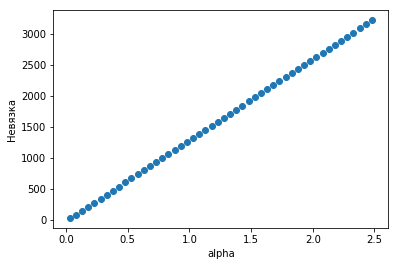

In [344]:
### Окно значений alpha: 0.03 - 2.5####
res = []

alphas = np.arange(0.03,2.5,0.05)
for alpha in alphas:
    r = calculate_for_alpha(alpha, 2500)
    res.append(np.sum(entropy(d / L,r / L) + entropy(r / L, d / L)))

plt.scatter(alphas, res)
plt.ylabel('Невязка')
plt.xlabel('alpha')
plt.show()

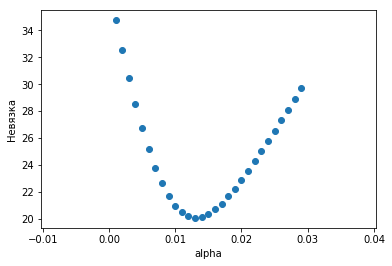

In [345]:
### Окно значений alpha: 0.001 - 0.03####
res = []
alphas = np.arange(0.001,0.03,0.001)

for alpha in alphas:
    r = calculate_for_alpha(alpha, 2500)
    res.append(np.sum(entropy(d / L,r / L) + entropy(r / L, d / L)))

plt.scatter(alphas, res)
plt.ylabel('Невязка')
plt.xlabel('alpha')
plt.show()

### Анализ

- При $\alpha > 2.5$ возникают, по-видимому, проблемы с сингулярностью в логарифмах, поэтому такие значения не берём в рассмотрение;
- Целевая функция в большей степени похожа на выпуклую функцию;
- Значени максимума кардинально отличается от значения в классической постановке задачи и составляет приблизительно $\alpha \approx 0.0125$;
- Интересно было бы посмотреть на поведение и, в частности, выпуклость правой(приближение справа) и левой(приближение слева) KL-расходимостей;

### Правая KL - расходимость

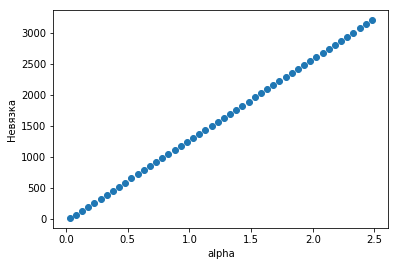

In [346]:
### Окно значений alpha: 0.03 - 2.5####
res = []

alphas = np.arange(0.03,2.5,0.05)
for alpha in alphas:
    r = calculate_for_alpha(alpha, 2500)
    res.append(np.sum(entropy(d / L,r / L)))

plt.scatter(alphas, res)
plt.ylabel('Невязка')
plt.xlabel('alpha')
plt.show()

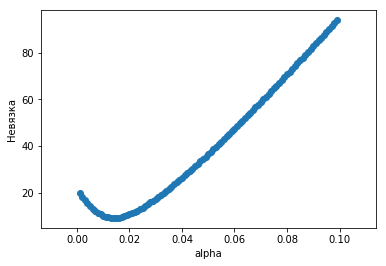

In [353]:
### Окно значений alpha: 0.001 - 0.1####
res = []
alphas = np.arange(0.001,0.1,0.001)

for alpha in alphas:
    r = calculate_for_alpha(alpha, 2500)
    res.append(np.sum(entropy(d / L,r / L)))

plt.scatter(alphas, res)
plt.ylabel('Невязка')
plt.xlabel('alpha')
plt.show()

### Левая KL-расходимость

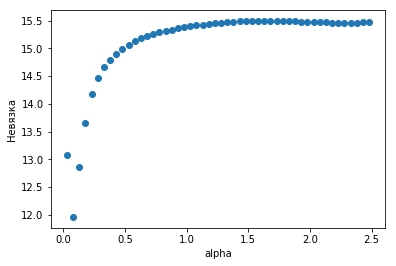

In [350]:
### Окно значений alpha: 0.03 - 2.5####
res = []

alphas = np.arange(0.03,2.5,0.05)
for alpha in alphas:
    r = calculate_for_alpha(alpha, 2500)
    res.append(np.sum(entropy(r / L,d / L)))

plt.scatter(alphas, res)
plt.ylabel('Невязка')
plt.xlabel('alpha')
plt.show()

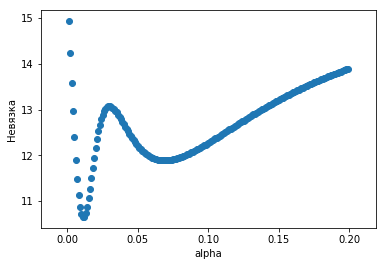

In [352]:
### Окно значений alpha: 0.001 - 0.2####
res = []
alphas = np.arange(0.001,0.2,0.001)

for alpha in alphas:
    r = calculate_for_alpha(alpha, 2500)
    res.append(np.sum(entropy(r / L,d / L)))

plt.scatter(alphas, res)
plt.ylabel('Невязка')
plt.xlabel('alpha')
plt.show()

## Выводы

- Правая, левая и симметричная KL - расходимости имеют различный характер, и оптимальное значение отличается от своего аналога в классической постановке задачи

- Постановка задачи в терминах вероятностей открывает путь в статистическое моделирование, которое представлено в следующей части работы

## Часть 3: метод статистического моделирования

Нашей целью в данной части работы было создание статистической модели, которая:

- Наследовала бы некоторые идеи классического подхода;
- Использовала бы сравнимое число обучаемых параметров;
- Допускала бы градиентный метод подбора параметров;

Обращаем внимание читателя на то, что приведённая ниже модель является результатом анализа численных экспериментов в чистом AD-HOC стиле и не претендует на простоту восприятия при первом прочтении.

## Описание модели

Напомним, что распределением Дирихле с параметрами $q = (q_1, \dots, q_n)$(-мультииндекс) является многомерное распределение с плотностью следующего вида:

$$Dir(x = (x_1,\dots, x_n)|q) = \frac{x_1^{q_1 - 1}x_2^{q_2 - 1}\dots x_n^{q_n - 1}}{B(q)},$$

$$\sum_{i = 1}^nx_i = 1,$$

$B(q)$ есть значение (многомерной)бета-функция в точке q.

Математическое ожидание распределения Дирихле является вектором $\bar{x}$ с компонентами 
$$\bar{x_i} = \frac{q_i}{\sum_{j=1}^kq_j}$$

Напомним, что значением функции softmax на векторе $x = (x_1,\dots,x_k)$ является вектор $z = (z_1, \dots, z_k)$ такой, что: 
$$z_i = \frac{e^{x_i}}{\sum_{j=1}^ke^{x_j}} =: softmax(x)_i$$ 

Зададим следующие параметры модели:

- вектор A:
$$A:=(A_1, \dots, A_n)^T$$
- вектор B:
$$B:=(B_1, \dots, B_n)^T$$
- число $\alpha$

Таким образом, модель будет иметь $2n+1$ обучаемый параметр.

Определеми также матрицу С:
$$C = softmax(AB^T),$$

где функция softmax применяется к матрице построчно.

Пусть теперь:
$$Q := 1 + softmax\left(\frac{C}{e^{\alpha \frac{T}{W}}}\right),$$

где softmax применяется к матрице построчно, 1 прибавляется к важдому элементу матрицы, столбцы матрицы времён Т делятся на столбец W(из классической модели), матричная экспонента понимается в виде поэлементной,а матрицы в числителе и знаменателе делятся также поэлементно.

Положим теперь, что распределение $p_i$:
$$\left(p_i(j):= \frac{d_{ij}}{L_i}\right)_{j=1}^n$$
следует закону распределения Дирихле с параметрами из i-ой строки матрицы Q: $$p_i = p_i(A,B,\alpha).$$

Целью оптимизации будет подбор параметров $(A,B,\alpha)$, дающих максимальное правдоподобие, то есть минимум следующей функции:

$$L = -\sum_{i=1}^n\log p_i(A,B,\alpha) = -\sum_{i=1}^n\log p_i(Q_{i,\cdot})$$

Для решения данной задачи градиентным методом применим возможности библиотеки Tensorflow.

Для построения предсказания для $\frac{d_{i,\cdot}}{L_i}$ возьмём математическое ожидание(см.формулу выше) распределения Дирихле с параметрами из i-ой строки оптимального значения матрицы Q. 

### Задаём параметры модели в Tensorflow

In [354]:
# Определение параметров модели в терминах вычислительного графа
alpha = tf.Variable(initial_value = 2.0,  name = 'alpha')#tf.constant( 1.0, name = 'beta')#
beta = tf.constant( 1.0, name = 'beta')

A = tf.Variable(initial_value = np.random.random((22,1)).astype('float32'), name = 'A1')
B = tf.Variable(initial_value = np.random.random((1,22)).astype('float32'), name = 'B1')

#alpha = tf.constant( 3.5, name = 'alpha')
#beta = tf.Variable(initial_value = 1.5,  name = 'beta')
#np.random.random((22,1)).astype('float32')
#np.random.random((1,22)).astype('float32')
#np.ones((22,1), dtype = 'float32')
#np.ones((1,22), dtype = 'float32')
#A2 = tf.Variable(initial_value = np.random.random((22,1)).astype('float32'), name = 'A2')
#B2 = tf.Variable(initial_value = np.random.random((1,22)).astype('float32'), name = 'B2')
#C = tf.Variable(initial_value = np.random.random((22,22)).astype('float32'))

#Определение матрицы С (здесь - Cs)
C = tf.matmul(A,B)
Cs = tf.nn.softmax(C, axis = 1)

# Данные из классической модели
Times = tf.placeholder(shape = (22,22), name = 'Times', dtype = 'float32')
Workers = tf.placeholder(shape = (1,22), name = 'Workers', dtype = 'float32')
Data_D = tf.placeholder(shape = (22,22), name = 'Data_D', dtype = 'float32')


#Weights = beta + tf.sigmoid(-Workers / Times * alpha)#tf.nn.softmax()
W_0 = C / tf.exp(alpha * Times / Workers)
TC = tf.placeholder(shape = (1,22), name = 'TC', dtype = 'float32')

#Определяем матрицу Q(здесь - Weights)
Weights = beta + tf.nn.softmax(W_0, axis = 1)#tf.nn.softmax( W_0, axis = 1)

#dists = Multinomial(total_count = TC, probs = Weights)#

#Определяем распределение Дирихле с параметрами Weights построчно
dists = Dirichlet(Weights)

v1 = dists.prob(Data_D)
v2 = tf.log(v1)

# Определяем целевую функцию
Loss = -tf.reduce_sum(v2)

# Определяем метод оптимизации - Adam, шаг фиксируем равным 0.001
optimizer = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(Loss)

### Запускаем процесс оптимизации

In [359]:
af = 0

vals_c = []
with tf.Session() as ss:
    ss.run(tf.global_variables_initializer())
    
    #число итераций - 10000
    for i in range(10000):

        _ , c, af = ss.run([optimizer, Loss, Weights], feed_dict={Times: T,
                                                     Workers: W.T,
                                                      Data_D: d / L,
                                                      TC: L.T})
        vals_c.append(c)


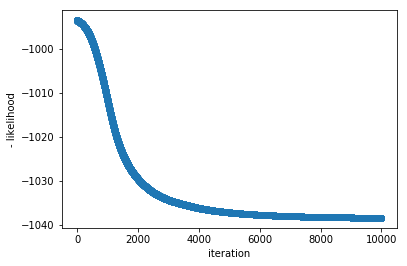

In [361]:
plt.scatter(range(10000), vals_c)
plt.ylabel('- likelihood')
plt.xlabel('iteration')
plt.show()

### Анализ результатов

Вычисляем построчно математические ожидания распределений Дирихле и вычисляем предсказания:

In [363]:
res = af / af.sum(axis = 1)

Вычислим невязку в терминах симметричной KL-метрики:

In [368]:
np.sum(entropy(d / L, res) + entropy(res, d / L ))

31.640512474393876

Невязка в терминах левой KL-метрики:

In [370]:
np.sum(entropy(res, d / L ))

14.08478180040572

In [ ]:
Невязка в терминах правой KL-метрики:

In [371]:
np.sum(entropy(d / L, res))

17.55573067398815

Классическая невязка:

In [372]:
np.sum((res * L - d)*(res * L - d))

59132.73909362238

Приведём внешний вид матрицы Q параметров распределений Дирихле. Не будем забывать про фиксированную 1, присутствующую в каждом элементе модели. Видно, что решение невырожденно.

In [377]:
af

array([[1.993224 , 1.0066278, 1.       , 1.       , 1.       , 1.0001483,
        1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
        1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
        1.       , 1.       , 1.       , 1.       ],
       [1.0994134, 1.8977089, 1.0000004, 1.0000002, 1.0000007, 1.0028528,
        1.0000011, 1.0000017, 1.0000007, 1.0000012, 1.0000006, 1.       ,
        1.0000001, 1.0000011, 1.0000001, 1.0000118, 1.0000005, 1.0000026,
        1.0000005, 1.0000005, 1.0000005, 1.0000006],
       [1.9733824, 1.0247084, 1.0000001, 1.       , 1.0000002, 1.001742 ,
        1.0000002, 1.0000007, 1.0000002, 1.0000001, 1.0001581, 1.       ,
        1.       , 1.0000004, 1.       , 1.0000017, 1.0000001, 1.0000002,
        1.0000044, 1.0000001, 1.0000001, 1.0000001],
       [1.9953272, 1.0025878, 1.       , 1.       , 1.       , 1.0020831,
        1.       , 1.       , 1.       , 1.       , 1.0000017, 1.       ,
        1.       , 1.000000

# Выводы и замечания

- Невязка в терминах KL- расходимостей близка к оптимальной для классической модели и соответствует значениям в непосредственной окрестности соответственных оптимальных значений $\alpha$ классической модели
- Классическая невязка не терпит никакой критики
- Это объясняется тем, что оптимизация правдоподобия на самом деле является оптимизацией в KL-терминах
- Возможно, для предсказания нужно брать не математическое ожидание, а что-то другое
- Возможно, саму модель стоит задать по-другому
- Эксперименты с мультиномиальным распределением успеха не возымели из-за возникающих синулярностей(мультиномиальная плотность была часто близкой к нулю)